In [2]:
import xarray as xr
import numpy as np
import matplotlib.colors as mcolors
from pathlib import Path

We have lots of datasets which we want to use as boundary conditions / inputs for BISICLES. However, they are all on slightly different grids, so we will need to regrid and make sure they all line up properly. We will use Mira's BISICLES post_relaxation data to get the BISICLES grid that we are targetting and try to manipulate everything else to match that.

In [19]:
data = Path('/Users/jonniebarnsley/data')

measures = xr.open_dataset(data / 'MEaSUREs/antarctica_ice_velocity_450m_v2.nc', chunks='auto')
bedmachine = xr.open_dataset(data / 'BedMachine/BedMachineAntarctica-v3.nc')
bisicles = xr.open_dataset('/Users/jonniebarnsley/Downloads/bedmachine_antarctica_v3_post-relax_1km.nc')

## BedMachine

(13333, 13333)


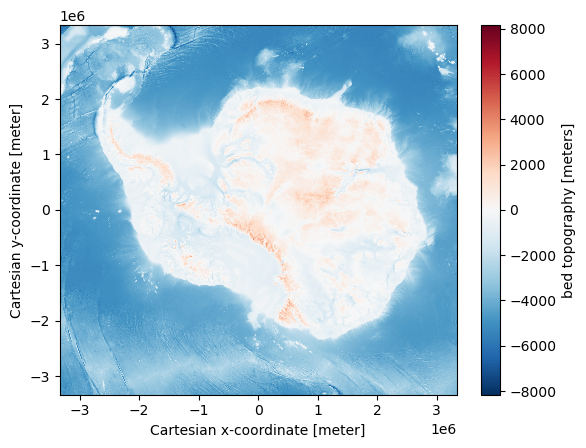

In [89]:
# compare bedmachine and bisicles first
print(bedmachine.bed.shape)
bedmachine.bed.plot()

(6144, 6144)


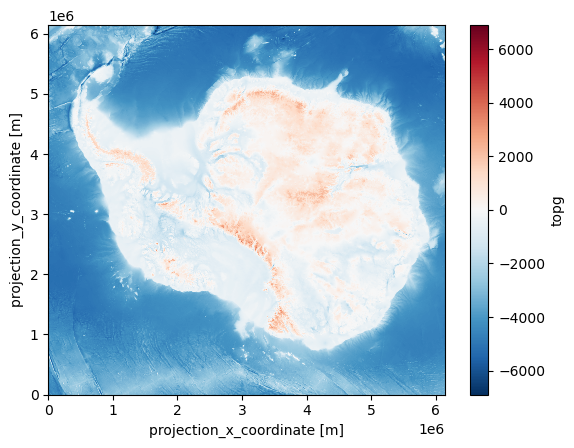

In [90]:
print(bisicles.topg.shape)
bisicles.topg.plot()
# different extend and resolution

In [20]:
bisicles
# not centered on south pole

<xarray.Dataset>
Dimensions:           (x: 6144, y: 6144)
Coordinates:
  * x                 (x) float64 500.0 1.5e+03 2.5e+03 ... 6.142e+06 6.144e+06
  * y                 (y) float64 500.0 1.5e+03 2.5e+03 ... 6.142e+06 6.144e+06
Data variables:
    crs               int32 ...
    thk               (y, x) float64 ...
    topg              (y, x) float64 ...
    c_one             (y, x) float64 ...
    c_third           (y, x) float64 ...
    c_third_jreg_300  (y, x) float64 ...
    c_third_jreg_50   (y, x) float64 ...
    mucoef            (y, x) float64 ...
Attributes: (12/16)
    Conventions:         CF-1.7
    component_0:         thk
    component_1:         topg
    component_2:         c_one
    component_3:         c_third
    component_4:         c_third_jreg_300
    ...                  ...
    num_components:      7
    num_levels:          1
    crs_origin_x:        0.0
    crs_origin_y:        0.0
    dx:                  1000.0
    Conversion_history:  slc removed this feature to see if it was causing chaos

In [22]:
# first convert bisicles into South Polar Stereographic coordinates by
# centering on the South Pole
x = bisicles.x
y = bisicles.y

centered = bisicles.copy()

centered['x'] = x - x.mean()
centered['y'] = y - y.mean()

bisicles

<xarray.Dataset>
Dimensions:           (x: 6144, y: 6144)
Coordinates:
  * x                 (x) float64 500.0 1.5e+03 2.5e+03 ... 6.142e+06 6.144e+06
  * y                 (y) float64 500.0 1.5e+03 2.5e+03 ... 6.142e+06 6.144e+06
Data variables:
    crs               int32 ...
    thk               (y, x) float64 ...
    topg              (y, x) float64 ...
    c_one             (y, x) float64 ...
    c_third           (y, x) float64 ...
    c_third_jreg_300  (y, x) float64 ...
    c_third_jreg_50   (y, x) float64 ...
    mucoef            (y, x) float64 ...
Attributes: (12/16)
    Conventions:         CF-1.7
    component_0:         thk
    component_1:         topg
    component_2:         c_one
    component_3:         c_third
    component_4:         c_third_jreg_300
    ...                  ...
    num_components:      7
    num_levels:          1
    crs_origin_x:        0.0
    crs_origin_y:        0.0
    dx:                  1000.0
    Conversion_history:  slc removed this feature to see if it was causing chaos

In [ ]:
bedmachine_1km = bedmachine.interp(x=centered.x, y = centered.y, method='nearest')

## MEaSUREs

In [7]:
measures
# MEaSUREs isn't big enough to fit BISICLES extent. Need to pad.

<xarray.Dataset>
Dimensions:       (x: 12445, y: 12445)
Coordinates:
  * x             (x) float64 -2.8e+06 -2.8e+06 -2.799e+06 ... 2.799e+06 2.8e+06
  * y             (y) float64 2.8e+06 2.8e+06 2.799e+06 ... -2.799e+06 -2.8e+06
    lat           (y, x) float64 dask.array<chunksize=(4096, 4096), meta=np.ndarray>
    lon           (y, x) float64 dask.array<chunksize=(4096, 4096), meta=np.ndarray>
Data variables:
    coord_system  |S1 ...
    VX            (y, x) float32 dask.array<chunksize=(5792, 5792), meta=np.ndarray>
    VY            (y, x) float32 dask.array<chunksize=(5792, 5792), meta=np.ndarray>
    STDX          (y, x) float32 dask.array<chunksize=(5792, 5792), meta=np.ndarray>
    STDY          (y, x) float32 dask.array<chunksize=(5792, 5792), meta=np.ndarray>
    ERRX          (y, x) float32 dask.array<chunksize=(5792, 5792), meta=np.ndarray>
    ERRY          (y, x) float32 dask.array<chunksize=(5792, 5792), meta=np.ndarray>
    CNT           (y, x) int32 dask.array<chunksize=(5792, 5792), meta=np.ndarray>
Attributes: (12/26)
    Conventions:               CF-1.6
    Metadata_Conventions:      CF-1.6, Unidata Dataset Discovery v1.0, GDS v2.0
    standard_name_vocabulary:  CF Standard Name Table (v22, 12 February 2013)
    id:                        vel_nsidc.CF16.nc
    title:                     MEaSURES Antarctica Ice Velocity Map 450m spacing
    product_version:            
    ...                        ...
    spatial_resolution:        450m
    time_coverage_start:       1995-01-01
    time_coverage_end:         2016-12-31
    project:                   NASA/MEaSUREs
    creator_name:              J. Mouginot
    license:                   No restrictions on access or use

In [8]:
# pad measures until it exceeds the extent of bisicles
N = 1000 # any big number will do
padded = measures.pad(x=(N, N), y=(N, N))

x = measures.x
dx = x[1] - x[0]
padded_axis_vals = np.arange(x.min()-N*dx, x.max()+N*dx+1, dx)
padded['x'] = padded_axis_vals
padded['y'] = -1*padded_axis_vals
padded

<xarray.Dataset>
Dimensions:       (x: 14445, y: 14445)
Coordinates:
  * x             (x) float64 -3.25e+06 -3.25e+06 ... 3.249e+06 3.25e+06
  * y             (y) float64 3.25e+06 3.25e+06 ... -3.249e+06 -3.25e+06
    lat           (y, x) float64 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    lon           (y, x) float64 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
Data variables:
    coord_system  |S1 ...
    VX            (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    VY            (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    STDX          (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    STDY          (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    ERRX          (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    ERRY          (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    CNT           (y, x) float64 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
Attributes: (12/26)
    Conventions:               CF-1.6
    Metadata_Conventions:      CF-1.6, Unidata Dataset Discovery v1.0, GDS v2.0
    standard_name_vocabulary:  CF Standard Name Table (v22, 12 February 2013)
    id:                        vel_nsidc.CF16.nc
    title:                     MEaSURES Antarctica Ice Velocity Map 450m spacing
    product_version:            
    ...                        ...
    spatial_resolution:        450m
    time_coverage_start:       1995-01-01
    time_coverage_end:         2016-12-31
    project:                   NASA/MEaSUREs
    creator_name:              J. Mouginot
    license:                   No restrictions on access or use

In [ ]:
measures_1km = padded.interp(x=centered.x, y=centered.y, method='nearest')
measures_1km

<xarray.Dataset>
Dimensions:       (y: 6144, x: 6144)
Coordinates:
    lat           (y, x) float64 dask.array<chunksize=(6144, 6144), meta=np.ndarray>
    lon           (y, x) float64 dask.array<chunksize=(6144, 6144), meta=np.ndarray>
  * x             (x) float64 -3.072e+06 -3.07e+06 ... 3.07e+06 3.072e+06
  * y             (y) float64 -3.072e+06 -3.07e+06 ... 3.07e+06 3.072e+06
Data variables:
    coord_system  |S1 ...
    VX            (y, x) float32 dask.array<chunksize=(6144, 6144), meta=np.ndarray>
    VY            (y, x) float32 dask.array<chunksize=(6144, 6144), meta=np.ndarray>
    STDX          (y, x) float32 dask.array<chunksize=(6144, 6144), meta=np.ndarray>
    STDY          (y, x) float32 dask.array<chunksize=(6144, 6144), meta=np.ndarray>
    ERRX          (y, x) float32 dask.array<chunksize=(6144, 6144), meta=np.ndarray>
    ERRY          (y, x) float32 dask.array<chunksize=(6144, 6144), meta=np.ndarray>
    CNT           (y, x) float64 dask.array<chunksize=(6144, 6144), meta=np.ndarray>
Attributes: (12/26)
    Conventions:               CF-1.6
    Metadata_Conventions:      CF-1.6, Unidata Dataset Discovery v1.0, GDS v2.0
    standard_name_vocabulary:  CF Standard Name Table (v22, 12 February 2013)
    id:                        vel_nsidc.CF16.nc
    title:                     MEaSURES Antarctica Ice Velocity Map 450m spacing
    product_version:            
    ...                        ...
    spatial_resolution:        450m
    time_coverage_start:       1995-01-01
    time_coverage_end:         2016-12-31
    project:                   NASA/MEaSUREs
    creator_name:              J. Mouginot
    license:                   No restrictions on access or use

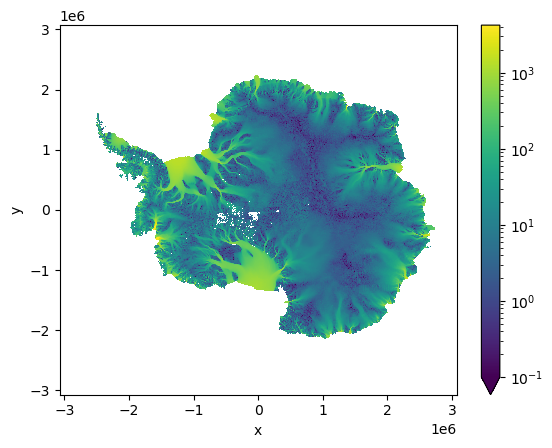

In [ ]:
speed = np.sqrt(measures_1km.VX**2 + measures_1km.VY**2)
speed.plot(norm = mcolors.LogNorm(vmin=0.1))

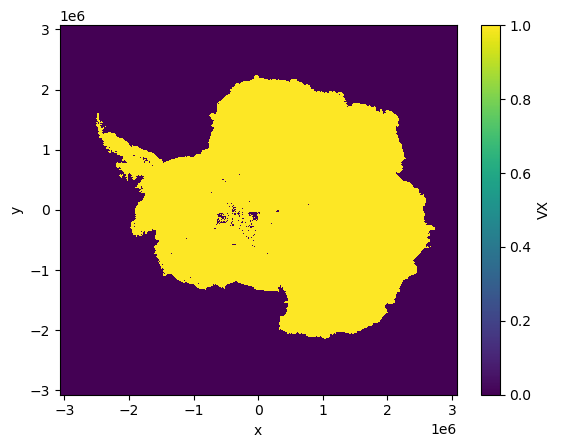

In [10]:
velc = (measures_1km.VX.fillna(0) != 0).astype(int)
velc.plot()

## Internal Energy

In [ ]:
energy = xr.open_dataset('/Users/jonniebarnsley/Downloads/antarctica_CTplusLW_8km.nc')
x = energy.x
y = energy.y

energy['x'] = x - x.mean()
energy['y'] = y - y.mean()

energy_1km = energy.interp(x=centered.x, y = centered.y, method='nearest')
energy_1km

<xarray.Dataset>
Dimensions:             (y: 6144, x: 6144)
Coordinates:
  * x                   (x) float64 -3.072e+06 -3.07e+06 ... 3.07e+06 3.072e+06
  * y                   (y) float64 -3.072e+06 -3.07e+06 ... 3.07e+06 3.072e+06
Data variables: (12/25)
    crs                 int32 -2147483647
    internalEnergy0000  (y, x) float64 nan nan nan nan nan ... nan nan nan nan
    internalEnergy0001  (y, x) float64 nan nan nan nan nan ... nan nan nan nan
    internalEnergy0002  (y, x) float64 nan nan nan nan nan ... nan nan nan nan
    internalEnergy0003  (y, x) float64 nan nan nan nan nan ... nan nan nan nan
    internalEnergy0004  (y, x) float64 nan nan nan nan nan ... nan nan nan nan
    ...                  ...
    internalEnergy0018  (y, x) float64 nan nan nan nan nan ... nan nan nan nan
    internalEnergy0019  (y, x) float64 nan nan nan nan nan ... nan nan nan nan
    internalEnergy0020  (y, x) float64 nan nan nan nan nan ... nan nan nan nan
    internalEnergy0021  (y, x) float64 nan nan nan nan nan ... nan nan nan nan
    internalEnergy0022  (y, x) float64 nan nan nan nan nan ... nan nan nan nan
    internalEnergy0023  (y, x) float64 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/33)
    Conventions:         CF-1.7
    component_0:         internalEnergy0000
    component_1:         internalEnergy0001
    component_10:        internalEnergy0010
    component_11:        internalEnergy0011
    component_12:        internalEnergy0012
    ...                  ...
    num_components:      24
    num_levels:          1
    crs_origin_x:        0.0
    crs_origin_y:        0.0
    dx:                  8000.0
    Conversion_history:  slc removed this feature to see if it was causing chaos

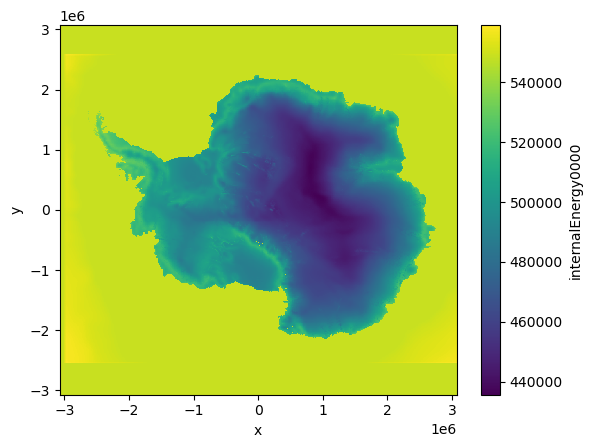

In [44]:
energy.internalEnergy0000.plot()

In [56]:
ds = xr.Dataset(
    data_vars = {
        'thk': bedmachine_1km.thickness,
        'topg': bedmachine_1km.bed,
        'c_third': centered.c_third,
        'xvel': measures_1km.VX,
        'yvel': measures_1km.VY,
        'velc': velc
    },

    coords={
        'x': centered.x,
        'y': centered.y
    }
)

ds = ds.fillna(0)

# return to original bisicles grid (not centered on south pole)
ds['x'] = bisicles.x
ds['y'] = bisicles.y

ds.to_netcdf('~/Downloads/inversion_inputs.nc')

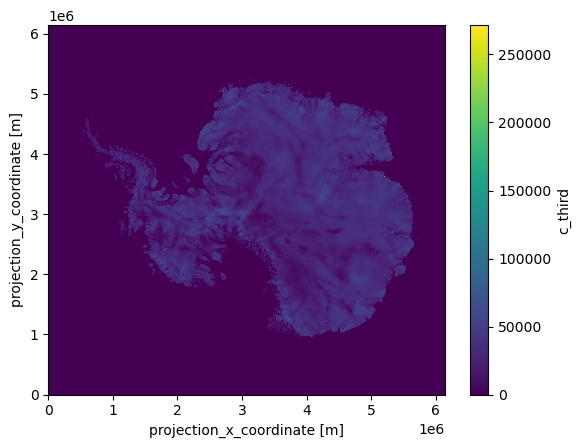

In [50]:
ds.c_third.plot()

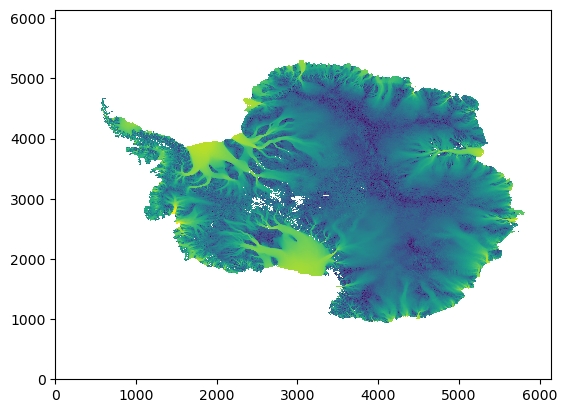

In [81]:
import matplotlib.pyplot as plt

mask = bisicles.thk > 0
vx = measures_on_bisicles_grid.VX.rename({'x':'y', 'y':'x'}).where(mask)
vy = measures_on_bisicles_grid.VY.rename({'x':'y', 'y':'x'}).where(mask)

speed = np.sqrt(vx.values**2 + vy.values**2)
fig, ax = plt.subplots()
ax.pcolormesh(speed, norm=mcolors.LogNorm(vmin=0.1))

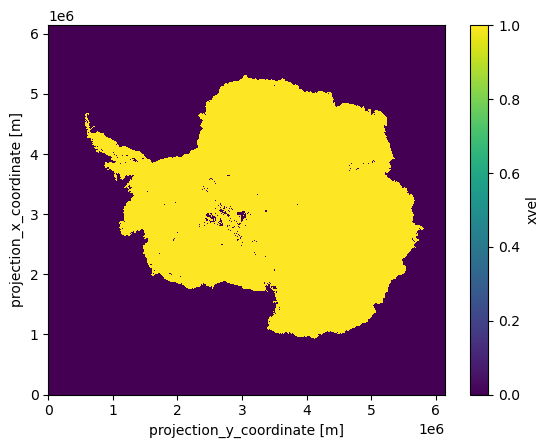

In [94]:
inversion_ds = xr.Dataset(
    data_vars = {
        'xvel': vx,
        'yvel': vy,
        'thk': bisicles.thk,
        'topg': bisicles.topg,
        'c_third': bisicles.c_third
    },
    coords={
        'x': bisicles.x,
        'y': bisicles.y
    }
)
where_velocity = inversion_ds.xvel.notnull()
where_velocity.plot()

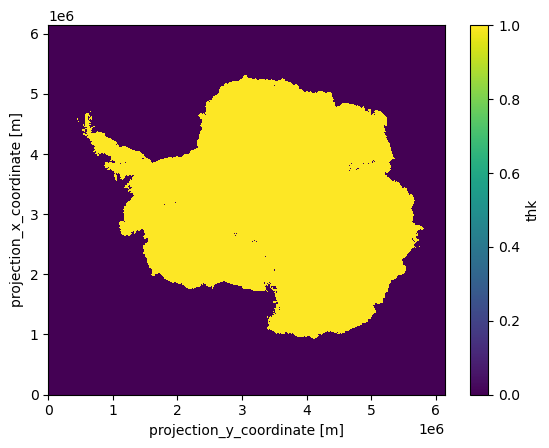

In [95]:
where_thk = inversion_ds.thk > 0
where_thk.plot()

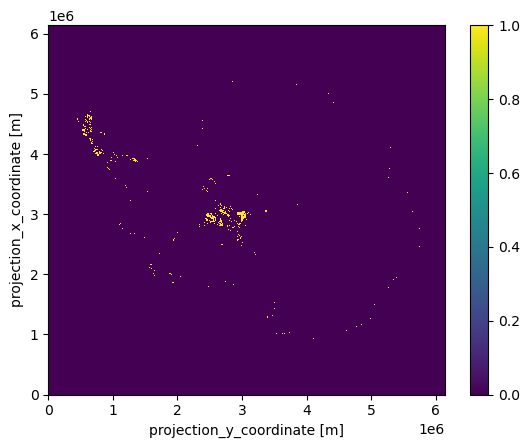

In [102]:
(~where_velocity & where_thk).plot()

In [17]:
file = xr.open_dataset('/Users/jonniebarnsley/Downloads/bedmachine_antarctica_v3_post-relax_1km.nc')
file

<xarray.Dataset>
Dimensions:           (x: 6144, y: 6144)
Coordinates:
  * x                 (x) float64 500.0 1.5e+03 2.5e+03 ... 6.142e+06 6.144e+06
  * y                 (y) float64 500.0 1.5e+03 2.5e+03 ... 6.142e+06 6.144e+06
Data variables:
    crs               int32 ...
    thk               (y, x) float64 ...
    topg              (y, x) float64 ...
    c_one             (y, x) float64 ...
    c_third           (y, x) float64 ...
    c_third_jreg_300  (y, x) float64 ...
    c_third_jreg_50   (y, x) float64 ...
    mucoef            (y, x) float64 ...
Attributes: (12/16)
    Conventions:         CF-1.7
    component_0:         thk
    component_1:         topg
    component_2:         c_one
    component_3:         c_third
    component_4:         c_third_jreg_300
    ...                  ...
    num_components:      7
    num_levels:          1
    crs_origin_x:        0.0
    crs_origin_y:        0.0
    dx:                  1000.0
    Conversion_history:  slc removed this feature to see if it was causing chaos

In [33]:
mask = np.invert(measures_on_bisicles_grid.conf)
file.x

<xarray.DataArray 'x' (x: 6144)>
array([5.0000e+02, 1.5000e+03, 2.5000e+03, ..., 6.1415e+06, 6.1425e+06,
       6.1435e+06])
Coordinates:
  * x        (x) float64 500.0 1.5e+03 2.5e+03 ... 6.142e+06 6.142e+06 6.144e+06
Attributes:
    standard_name:  projection_x_coordinate
    units:          m

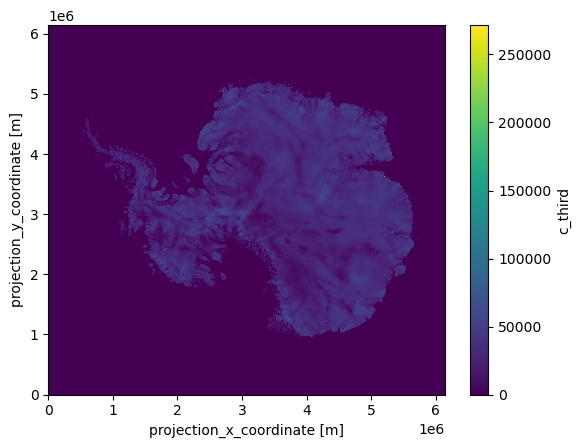

In [46]:
bisicles.c_third.plot()

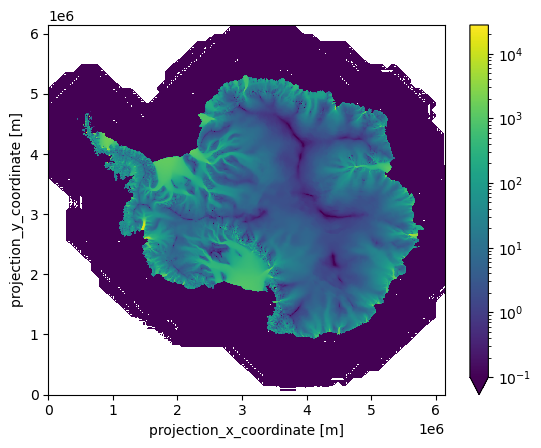

In [69]:
file = xr.open_dataset('/Users/jonniebarnsley/Downloads/iteration_0.nc')
speed = np.sqrt(file.xVel**2 + file.yVel**2)
speed.plot(norm=mcolors.LogNorm(vmin=0.1))

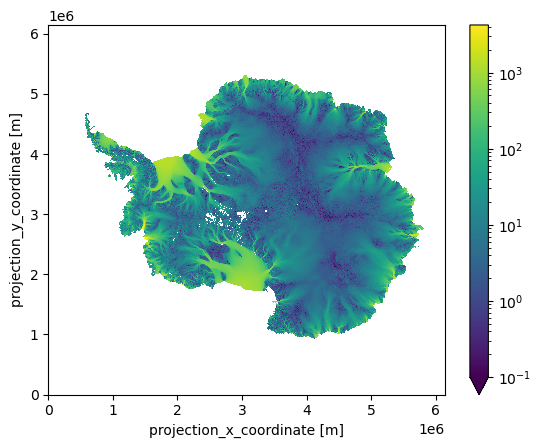

In [75]:
observed_speed = np.sqrt(ds.xvel**2 + ds.yvel**2)
observed_speed.plot(norm=mcolors.LogNorm(vmin=0.1))

In [74]:
speed

<xarray.DataArray (y: 768, x: 768)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * x        (x) float64 4e+03 1.2e+04 2e+04 ... 6.124e+06 6.132e+06 6.14e+06
  * y        (y) float64 4e+03 1.2e+04 2e+04 ... 6.124e+06 6.132e+06 6.14e+06